## Creating synthetic data


Loading the VERDICT MODEL 
\begin{equation}
 E_{\textrm{VERDICT}}= \underbrace{f_{\textrm{Tumor}}\overbrace{E(D|\lambda_{\textrm{intra}})}^{\textrm{Sphere}}}_{\textrm{Tumor Cells}} + \underbrace{f_{\textrm{extra}}\overbrace{E(\cdot|\lambda_{iso})}^{\textrm{Ball}}}_{\textrm{Hindered Extra-Cellular}}+\underbrace{f_{blood}\overbrace{E(\lambda_\parallel, \boldsymbol{\mu})}^{\textrm{Stick}}}_{\textrm{Vascular}}
\end{equation}

In [3]:
# load the necessary modules
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel, MultiCompartmentSphericalHarmonicsModel
import numpy as np
from scipy.stats import rice
import matplotlib as mpl
import matplotlib.gridspec as gridspec


sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])
verdict_mod.parameter_names

verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9) #2
verdict_mod.set_parameter_optimization_bounds('C1Stick_1_lambda_par', [3.05e-9, 10e-9])

Loading acquisition scheme

In [4]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join

acquisition_path_GS55 = "/Users/theavage/Documents/Master/Data/GS55 - long acquisition"

scheme= acquisition_scheme_from_schemefile(join(acquisition_path_GS55,"GS55_long_protocol2.scheme"))
scheme.print_acquisition_info


Acquisition scheme summary

total number of measurements: 160
number of b0 measurements: 40
number of DWI shells: 39

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |0                        |3.2239999999999998|32.08     |53.5 
1           |3         |83              |60                       |3.2239999999999998|32.08     |53.5 
2           |1         |0               |0                        |4.715999999999999|23.496    |49.099999999999994
3           |3         |84              |49                       |4.715999999999999|23.496    |49.099999999999994
4           |1         |0               |0                        |4.848      |31.112000000000002|55.199999999999996
5           |3         |187             |61                       |4.848      |31.112000000000002|55.199999999999996
6           |1         |0               |0                        |6.468      |32.148    |56.800000000000004
7     

## Creating parameter arrays

With random values of R and the IC,EES and VASC volume fractions

In [5]:
def all_comb(ic,ec,vasc,radi):

    comb= []

    for i in ic:
        for j in ec:
            for k in vasc:
                if i+j+k == 1:
                    for r in radi:
                        comb.append([r,2,1,3.05000000e-09,i,j,k])
    return comb

In [6]:
def fill(comb_arr,pixels):

    for i in range(pixels):
        comb_arr.append([np.random.uniform(0.001e-6,0.002e-6),2, 1, 3.05e-09,0.33,0.33,0.33])
    
    return comb_arr

In [7]:
#Creating parameter vector

ranges = np.arange(0.1,1.1,0.1)
ic = ranges; ec = ranges; vasc = ranges
radi = np.arange(0.02e-6,30e-6,1e-6)

all_combinations = all_comb(ic,ec,vasc,radi)

final = fill(all_combinations,4)

parameter_vector = np.array(final).reshape(32,32,7)


Visualization of the parameters:

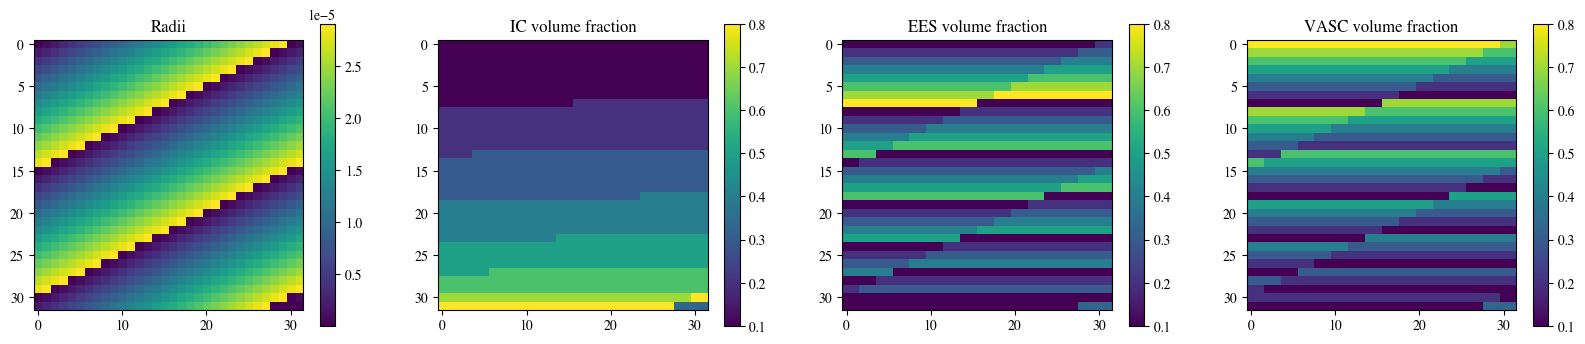

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import isin
%matplotlib inline

plt.rcParams["font.family"] = "times"
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

fig, ax = plt.subplots(1,4,figsize=(20,20))
names = ['Radii','IC volume fraction','EES volume fraction', 'VASC volume fraction']

image = ax[0].imshow(parameter_vector[:,:,0])
fig.colorbar(image,ax=ax[0],shrink=0.2)
ax[0].set_title(names[0])

for i in [1,2,3]:
    image = ax[i].imshow(parameter_vector[:,:,i+3])
    fig.colorbar(image,ax=ax[i],shrink=0.2)
    ax[i].set_title(names[i])



## Simulating new data from fake parameters
and visualizing 

In [9]:
simulated_signal = verdict_mod.simulate_signal(scheme,parameter_vector)

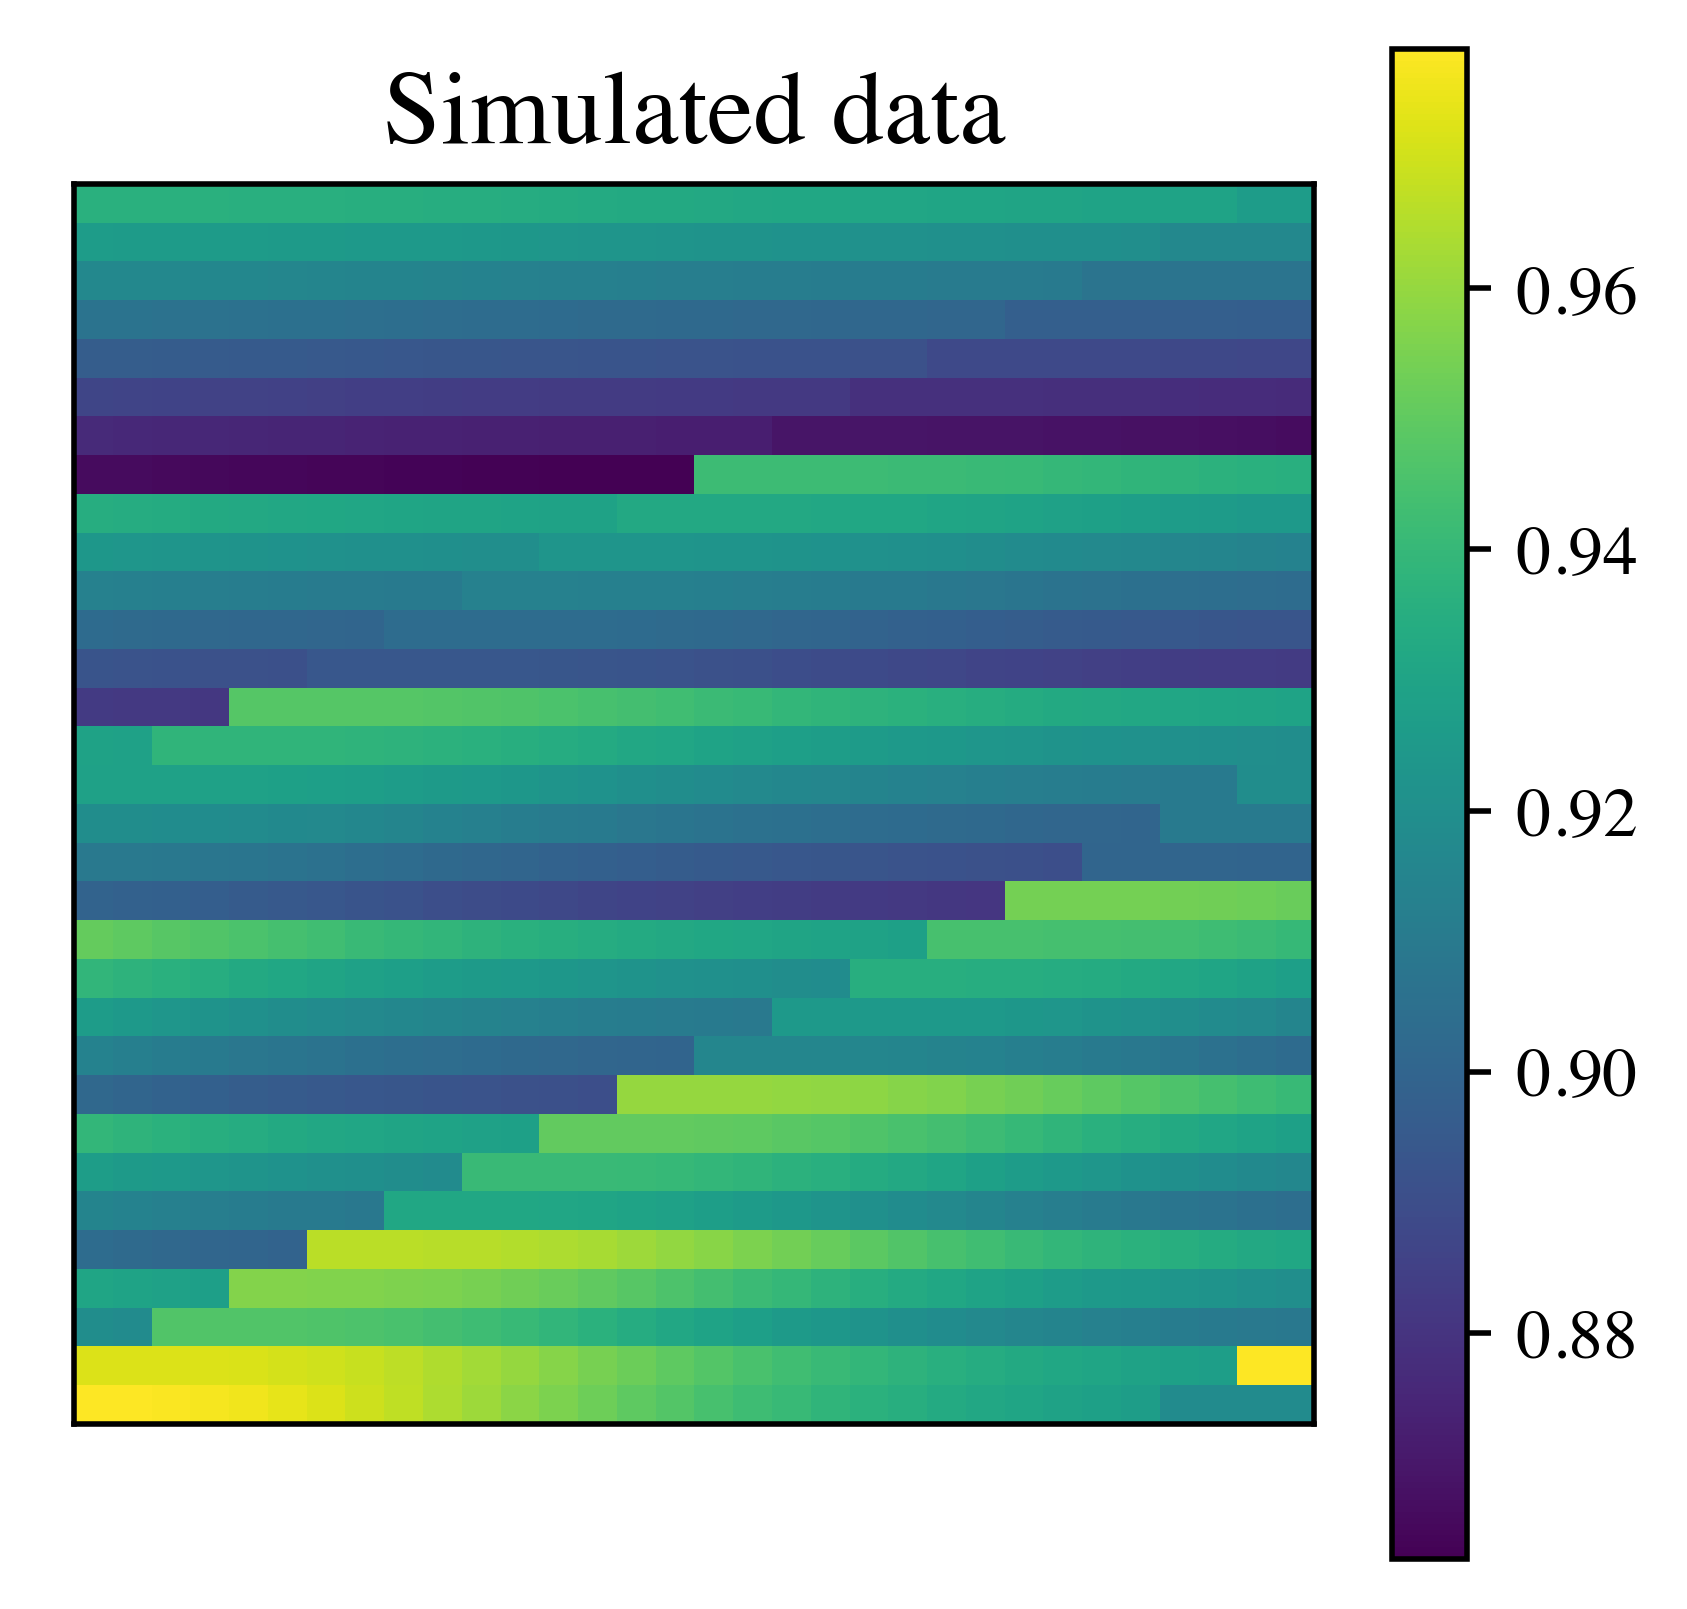

In [293]:
#Visualization of simulated signal
fig, ax = plt.subplots(1,figsize=(4,4))

image = ax.imshow(simulated_signal[:,:,1])
title = ax.set_title('Simulated data',fontsize=15)
cb = fig.colorbar(image,ax=ax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


## Adding noise

Normal distribution noise

In [11]:
# Normal noise
noise = np.random.normal(0,.005,simulated_signal.shape)
new_signal = simulated_signal+noise

Rice distribution noise

In [181]:
def rician_noise(signal,TE=50,b=1000):

    scale = 0.0001*np.sqrt(b)*(TE/30)**2

    rician_noise = rice.rvs(0.8,scale=scale,size = signal.shape)
    rician_image = signal*(1-rician_noise)

    return rician_noise, rician_image

In [24]:
def plot_augmentations(rows,cols,images,names,colorbar=True,title=None):

    plt.rcParams["figure.dpi"] = 300

    fig,axes = plt.subplots(rows,cols,figsize=(10,5))


    if title is not None:
        fig.suptitle(title,fontsize=20)

    for i,ax in zip(range(len(images)),axes.flat):

        image = ax.imshow(images[i][:,:,1])
        title = ax.set_title(names[i])
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

        if colorbar == True:
            cb=fig.colorbar(image,ax=ax,shrink=1/cols)
        
    if cols*rows > len(images):
        to_remove = len(images)-cols*rows
        fig.delaxes(axes[-1][to_remove])

    plt.tight_layout()

Visualizing images with noise

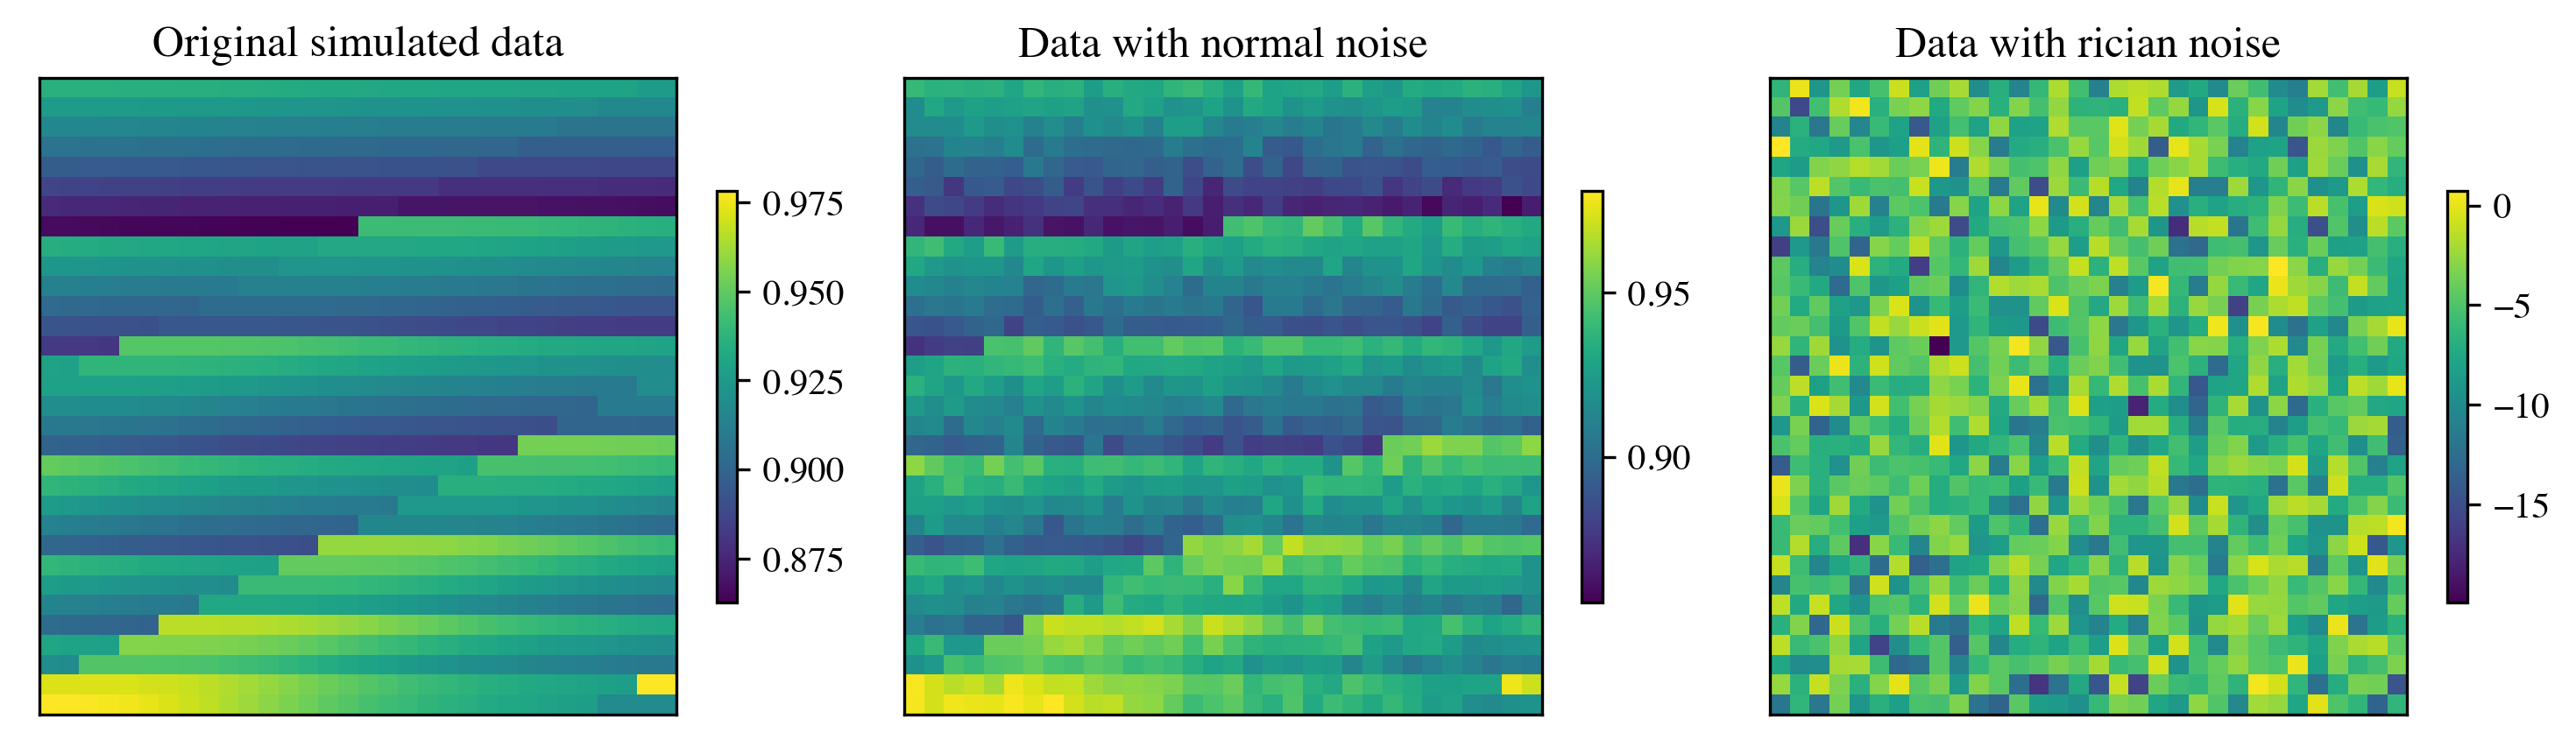

In [37]:
# Visualization

_,ric = rician_noise(simulated_signal)

plot_augmentations(1,3,[simulated_signal,new_signal,ric],['Original simulated data','Data with normal noise','Data with rician noise'])


Visualizing different rician noises for different b-values

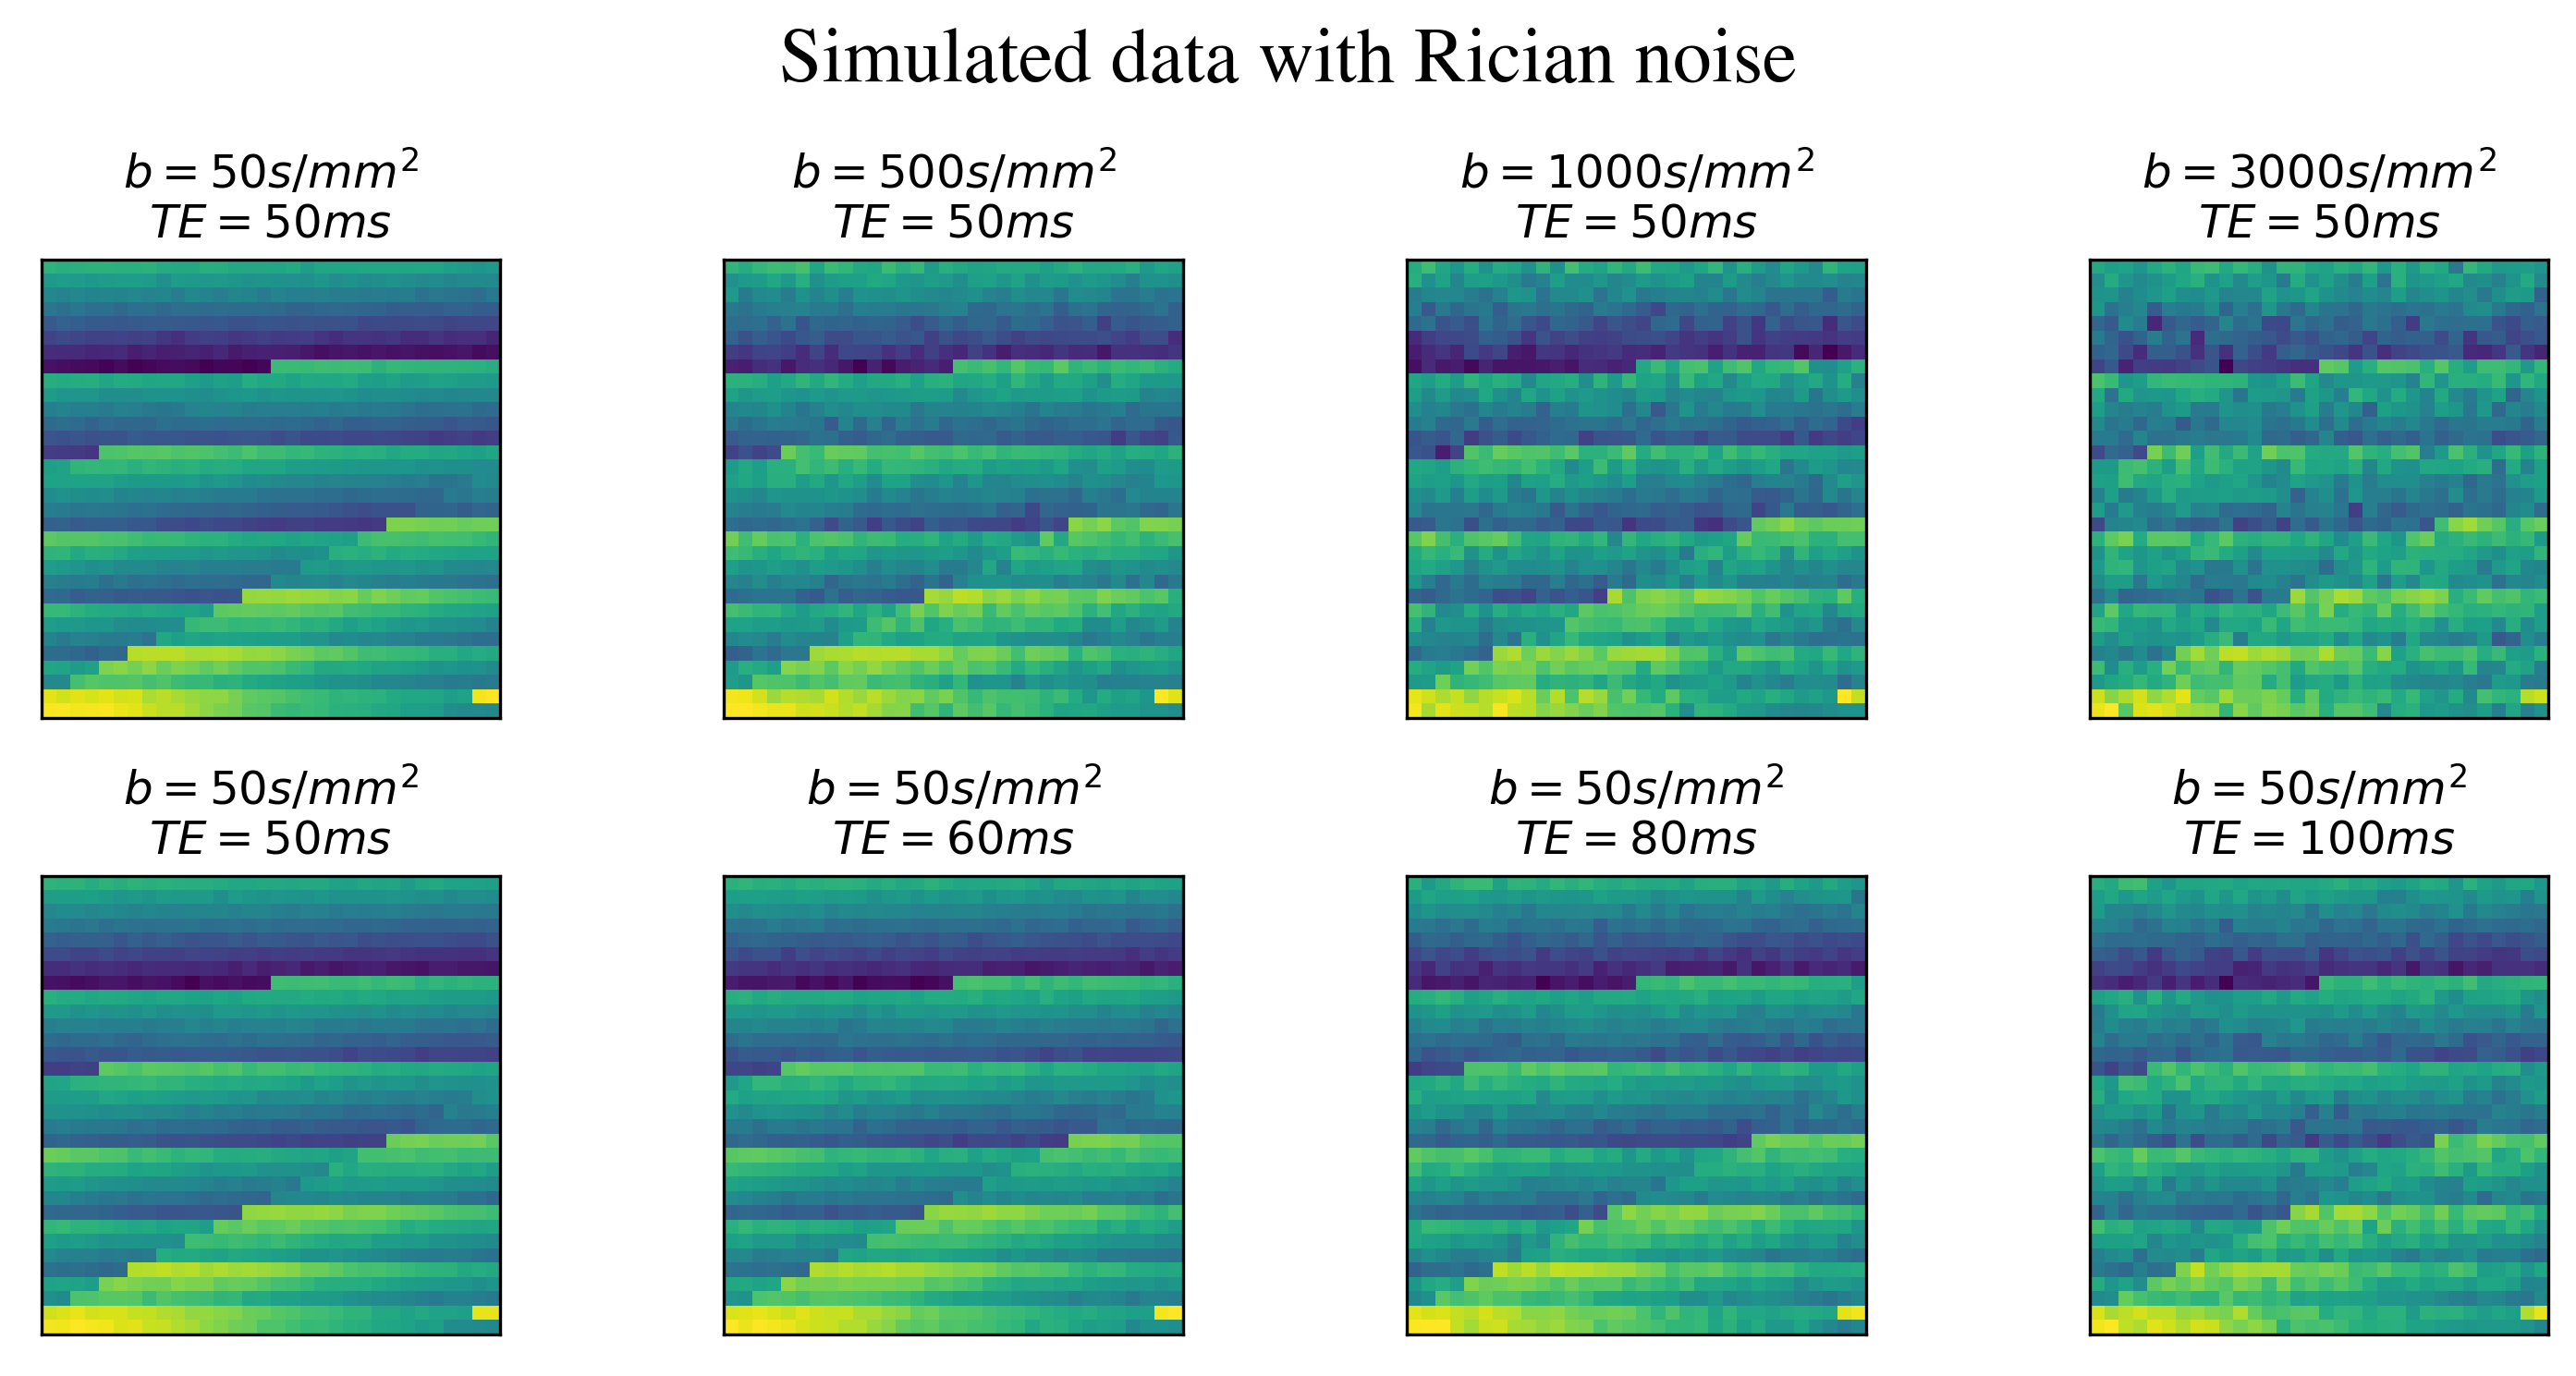

In [182]:
rician_images = []; names = []
b_values = [50,500,1000,3000]
TE_values = [50,60,80,100] #[ms]

for b in b_values:
    _, rician_image = rician_noise(simulated_signal,TE_values[0],b)
    rician_images.append(rician_image)
    names.append('$b = %d s/mm^2$\n$TE = %d ms $' %(b,TE_values[0]))


for TE in TE_values:
    _,rician_image = rician_noise(simulated_signal,TE,b_values[0])
    rician_images.append(rician_image)
    names.append('$b = %d s/mm^2$\n$TE = %d ms $' %(b_values[0],TE))


plot_augmentations(2,4,rician_images,names,colorbar=False,title='Simulated data with Rician noise')

## Testing

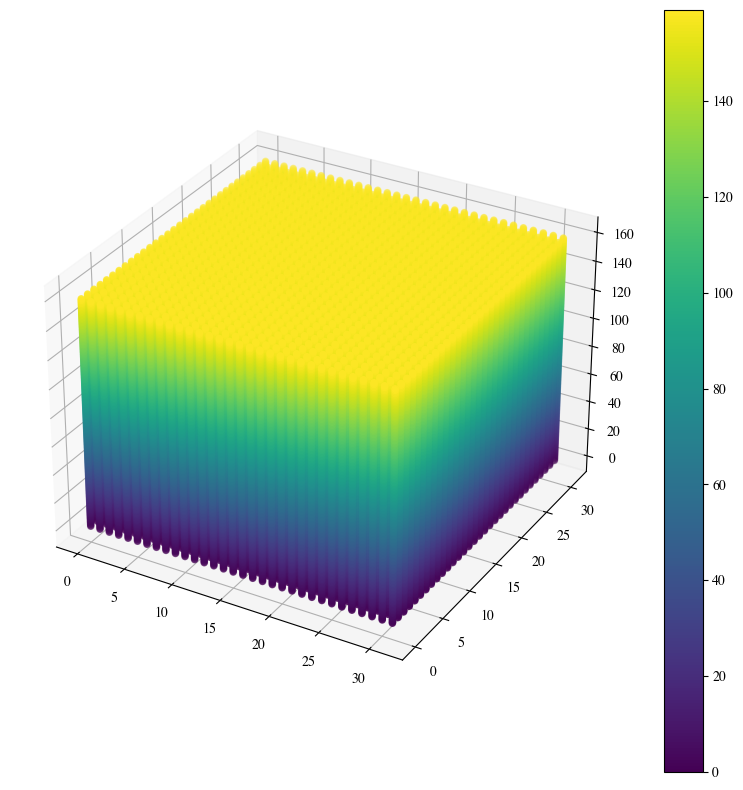

In [299]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = [8,8]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
image = fig.add_subplot(111,projection='3d')

x,y,z = simulated_signal.nonzero()

p = image.scatter3D(x,y,z,c=z)

fig.colorbar(p,ax=image)


# Visualization of noise distribution in air voxels

Text(0, 0.5, 'Density')

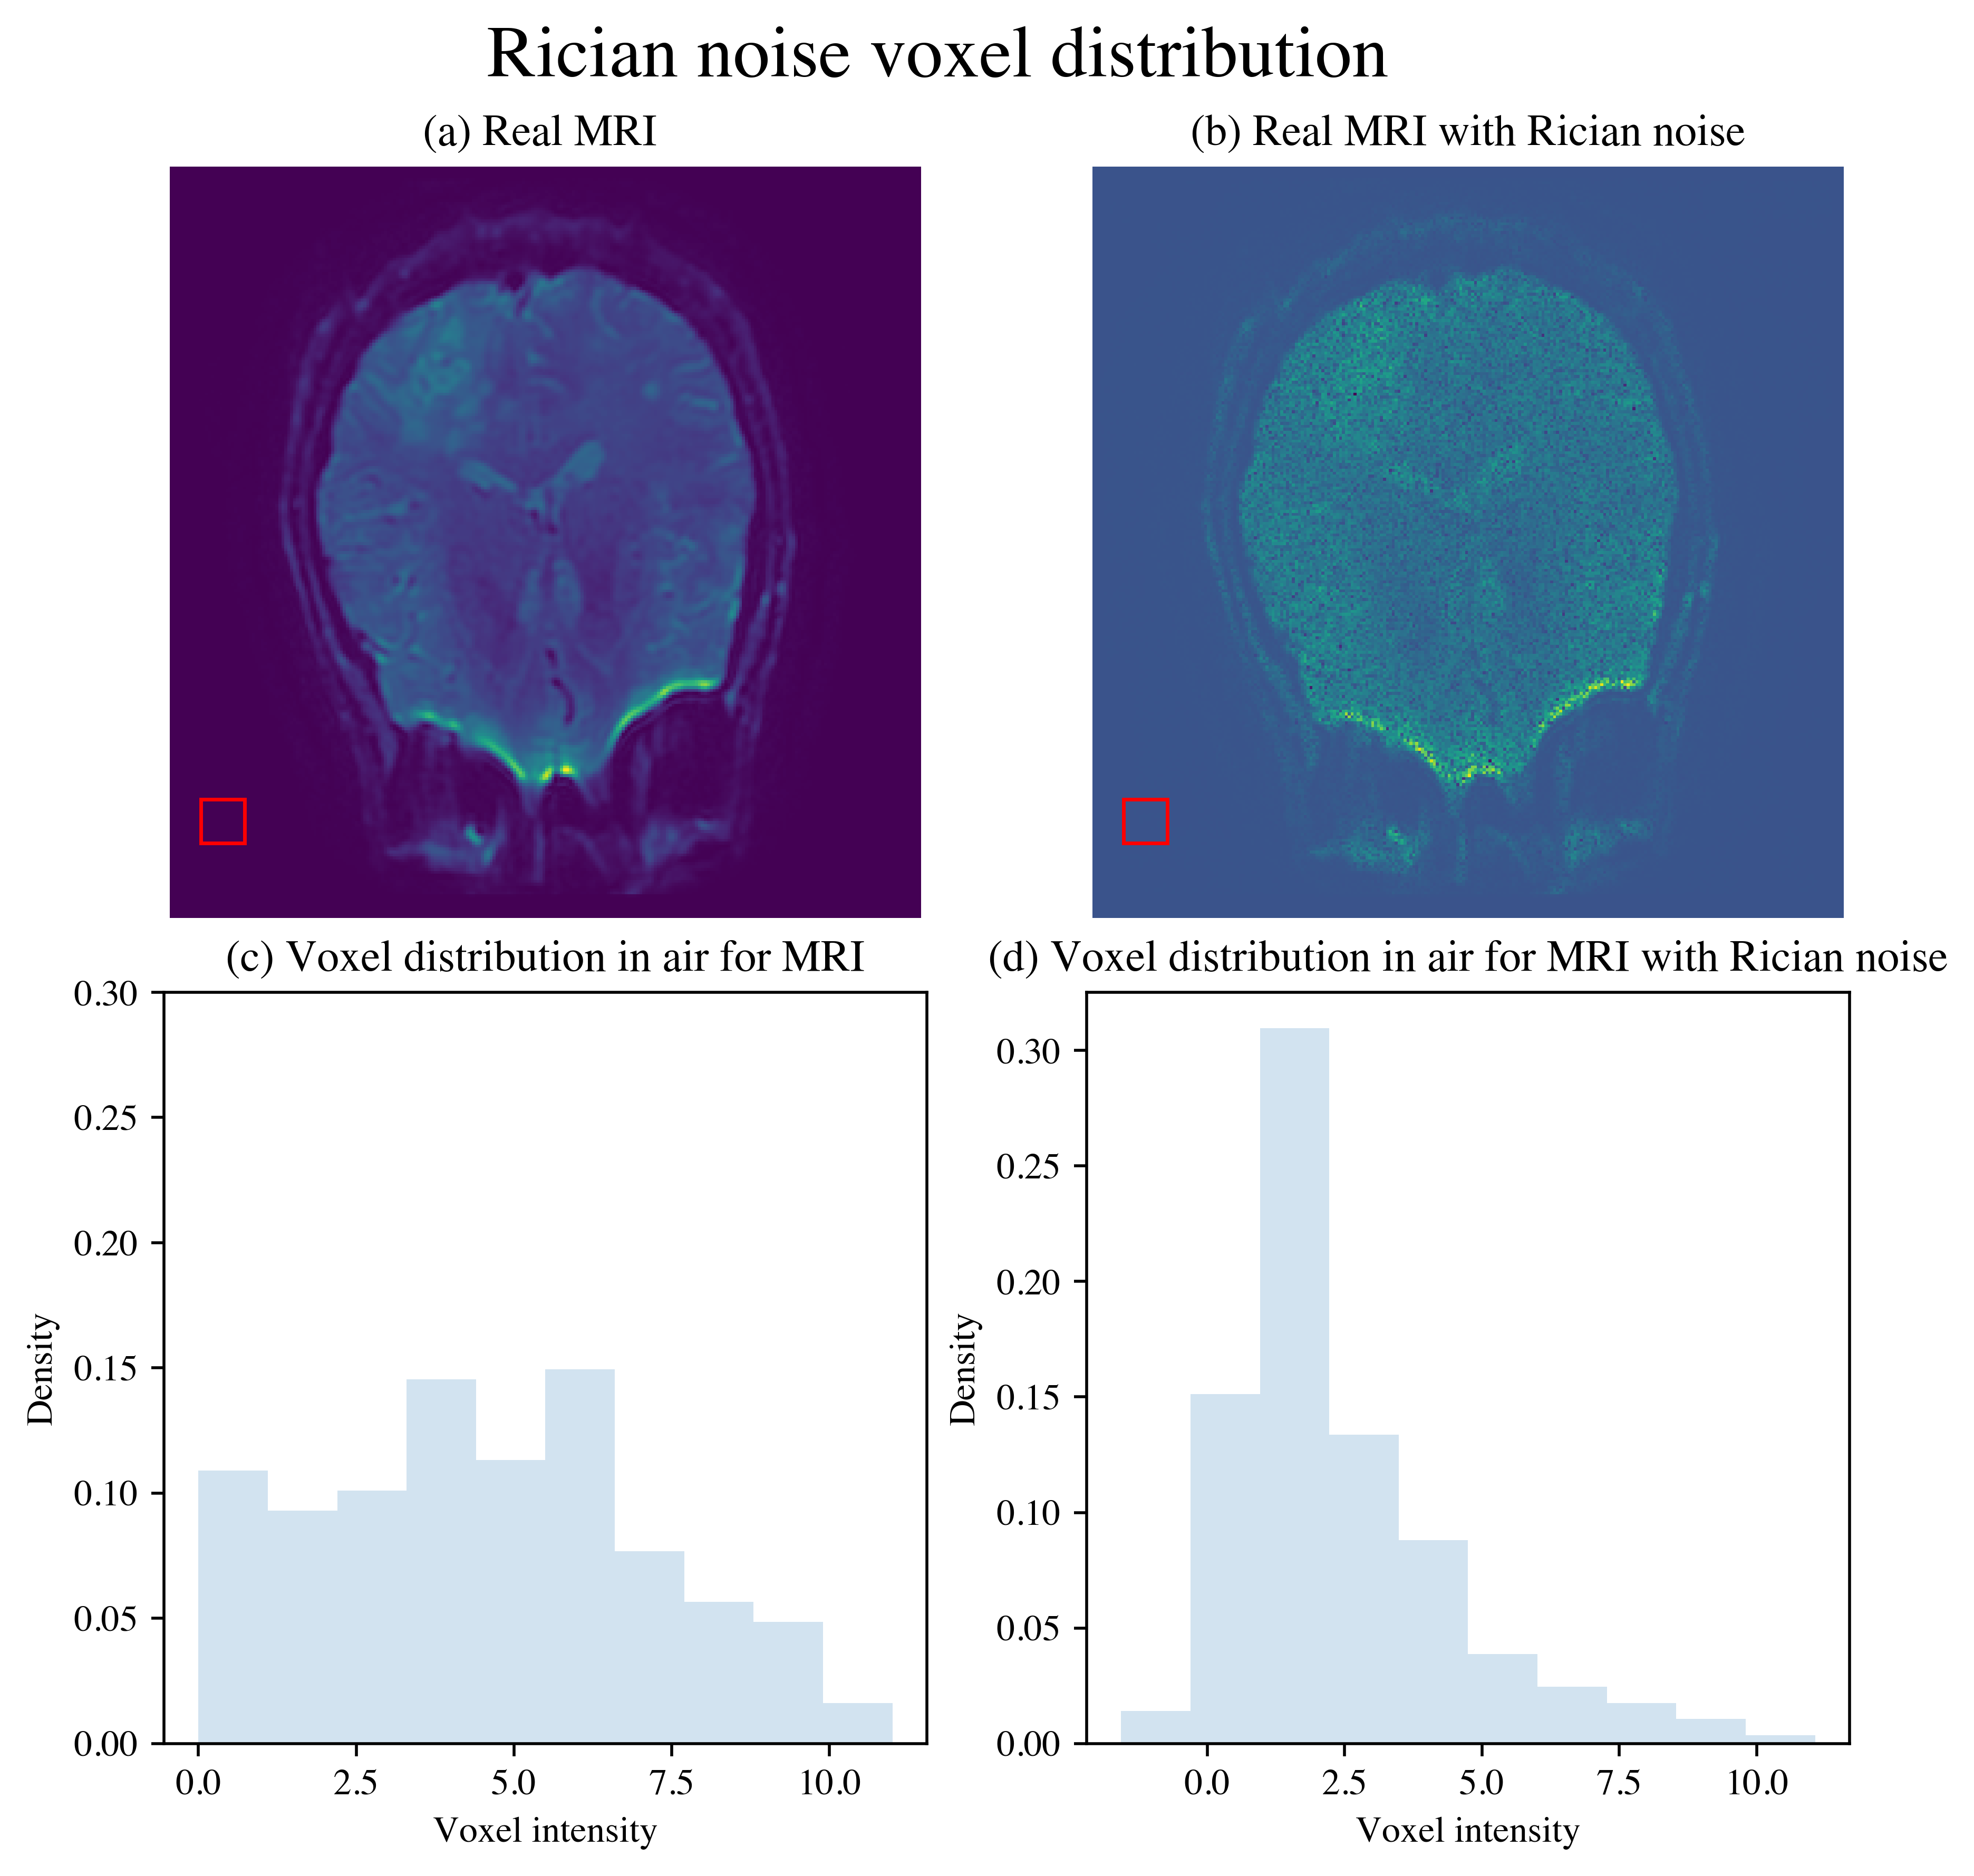

In [292]:
import dipy
real_image = dipy.data.fetcher.load_nifti_data(join(acquisition_path_GS55,"GS55_all.nii.gz"))
noise, noisy_real_img = rician_noise(real_image[:,:,:,0],200,5000)

fig, ax = plt.subplots(2,2,constrained_layout=True,figsize=(7,7))
fig.suptitle('Rician noise voxel distribution',fontsize=20)

ax=ax.flat
image = ax[0].imshow(real_image[:, :, 8, 0].T)
rect = patches.Rectangle((10,215),15,15,linewidth=1,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)
ax[0].set_axis_off()
ax[0].set_title('(a) Real MRI ')

image = ax[1].imshow(noisy_real_img[:, :, 8].T)
rect = patches.Rectangle((10,215),15,15,linewidth=1,edgecolor='r',facecolor='none')
ax[1].add_patch(rect)
ax[1].set_axis_off()
ax[1].set_title('(b) Real MRI with Rician noise')


ax[2].hist(real_image[10:25,225:240,8,0].flatten(), density=True, histtype='stepfilled', alpha=0.2)
ax[2].set_title('(c) Voxel distribution in air for MRI')
ax[2].set_ylim([0,0.3])
ax[2].set_xlabel('Voxel intensity')
ax[2].set_ylabel('Density')


ax[3].hist(noisy_real_img[10:25,225:240,0].flatten(), density=True, histtype='stepfilled', alpha=0.2)
ax[3].set_title('(d) Voxel distribution in air for MRI with Rician noise')
ax[3].set_xlabel('Voxel intensity')
ax[3].set_ylabel('Density')
